# Plots
<hr style="clear:both">

This notebook presents and displays our plot illustrating out story.


**Project Mentor:** [Shuo Wen](http://personnes.epfl.ch/shuo.wen) ([Email](shuo.wen@epfl.ch)),
**Authors:** Mahmoud Dokmak, Matthieu Borello, Léo Brunneau, Loïc Domingos, Bastien Armstrong

<hr style="clear:both">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats
from dash.dependencies import Input, Output
import dash
from dash import dcc, html
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact
from src.utils.results_utils import *

In [2]:
movies = pd.read_pickle('./data/Success_Metric.pkl')
movies_non_normalized = pd.read_pickle('./data/Data_For_Score.pkl')
movies.head()

freebase_movie_id imdb_id  item_id                        movie_name  \
30973         /m/083skw  031381      NaN                Gone with the Wind   
9888           /m/0k4d7  029583      NaN   Snow White and the Seven Dwarfs   
1036         /m/04j1zjw  034492      NaN                             Bambi   
66323          /m/0dtfn  076759      NaN  Star Wars Episode IV: A New Hope   
18216          /m/0dr_4  120338   1721.0                           Titanic   

      combined_release_date  Box_Office  \
30973            1939-12-15    0.143767   
9888             1937-12-21    0.149518   
1036             1942-08-14    0.096125   
66323            1977-05-25    0.278692   
18216            1997-11-18    0.785462   

       inflation_adjusted_box_office_revenue     movie_countries_final  \
30973                               0.996126  United States of America   
9888                                1.000000  United States of America   
1036                                0.567962  United States of America   
66323                               0.442916  United States of America   
18216                               0.471324  United States of America   

                                      movie_genres_final  sa_score  \
30973  [Film adaptation, Costume drama, Roadshow thea...  0.619947   
9888   [Romance Film, Musical, Fantasy, Family Film, ...  0.619947   
1036   [Adventure, Children's/Family, Animation, Comi...  0.619947   
66323  [Science Fiction, Adventure, Fantasy, Coming o...  0.619947   
18216  [Tragedy, Costume drama, Historical fiction, A...  0.592075   

       popularity    rating  success_score  success_metric_scaled  
30973         1.0  0.785789      22.186218               5.000000  
9888          1.0  0.696421      21.949103               4.944015  
1036          1.0  0.684211      18.456170               4.119294  
66323         1.0  0.810947      17.836009               3.972866  
18216         1.0  0.714080      17.689057               3.938169

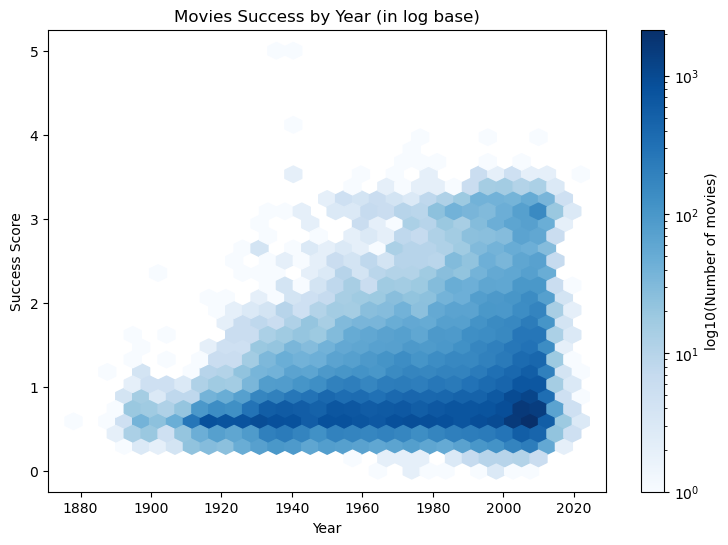

In [6]:
# Hexbin plot
# Create a copy to not modify our final dataframe
# Keeping only the year as we are looking at year distribution
success_by_year = movies.copy()
success_by_year['year'] = pd.to_datetime(success_by_year['combined_release_date']).dt.year
plt.figure(figsize=(9, 6))
plt.hexbin(success_by_year['year'], success_by_year['success_metric_scaled'],gridsize=30,cmap='Blues',bins='log')
plt.colorbar(label='log10(Number of movies)')

# Set the title and labels
plt.xlabel('Year')
plt.ylabel('Success Score')
plt.title('Movies Success by Year (in log base)')

plt.savefig('plots/movie_success_hexbin.png', dpi=300, bbox_inches='tight')
plt.show()



This plot represent the number of movies of a particular genre released per year.

This plot represent the distribution of the success metric assigned to the movies.


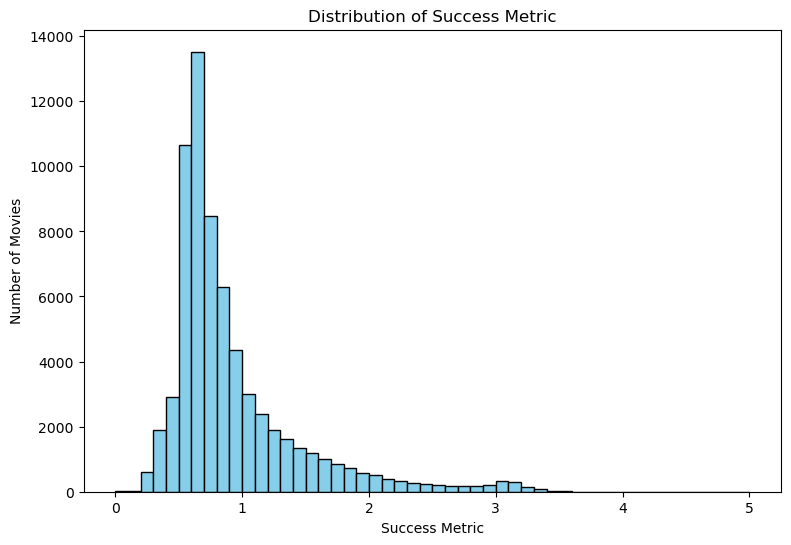

In [7]:
# Create a histogram of the Success_metric
plt.figure(figsize=(9, 6))
plt.hist(movies['success_metric_scaled'].dropna(), bins=50, color='skyblue', edgecolor='black')

# Set the title and labels
plt.title('Distribution of Success Metric')
plt.xlabel('Success Metric')
plt.ylabel('Number of Movies')

# Show the plot
plt.savefig('plots/success_metric_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Line plot
# Keeping only the year as we are looking at year distribution
movies['year'] = pd.to_datetime(movies['combined_release_date']).dt.year
# Explode the genres to have one genre per row to be able to count them
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
n_genre_per_year = movies.explode('movie_genres_final')
# Keep only the top 20 genres
genre_counts = n_genre_per_year['movie_genres_final'].value_counts()
best_genres = genre_counts.head(20).index.tolist()
n_genre_per_year = n_genre_per_year[n_genre_per_year['movie_genres_final'].isin(best_genres)]
# Ensure the order of the genres
n_genre_per_year['movie_genres_final'] = pd.Categorical(n_genre_per_year['movie_genres_final'],categories=best_genres, ordered=True)
# Count the number of movies per genre per year
n_genre_per_year = n_genre_per_year.groupby(['year', 'movie_genres_final']).size().reset_index(name='movie_count')
# Generate the line plot as before
fig = px.line(n_genre_per_year, x='year', y='movie_count', color='movie_genres_final',
              title='Top 15 Movies Count by Genre Over Time',
              labels={'year': 'Release Year', 'movie_count': 'Number of Movies', 'movie_genres_final': 'Genres'},
            #   height=420,
            #   width=720
              )

# Update layout to set white background
fig.update_layout(
    legend=dict(itemclick="toggleothers")  # Allow toggling of the genres in the legend
)

# Show the plot
fig.write_html('plots/movie_counts_by_genre.html', full_html=True, default_width='730px', default_height='430px')
fig.show()

In [9]:
# Histogram
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=movies['success_metric_scaled'],
    nbinsx=75,
    marker_color='skyblue',
    opacity=0.7
))

fig.update_layout(
    title='Success Score Distribution',
    xaxis_title='Success Score',
    yaxis_title='Number of Movies',
    template='plotly_white',
    hovermode='closest',
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=4000,
        tickformat='d',
    ),
    # height=420,
    # width=720,
)

fig.write_html('plots/success_score_distribution.html', full_html=False)
fig.show()


In [10]:
# Donut chart
# Movies have more than one genre, so we need to explode the genres to count them
movies_pie_df = movies.copy()
movies_pie_df['movie_genres_final'] = movies_pie_df['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
genre_per_film = movies.explode('movie_genres_final')
# Put the genres that are not in the top 20 represented in our dataframe in the "Others" category
n_genres = genre_per_film['movie_genres_final'].value_counts()
top_20_genres = n_genres.head(20).index.tolist()
genre_per_film['movie_genres_final'] = genre_per_film['movie_genres_final'].apply(lambda x: x if x in top_20_genres else 'Others')
# Recalculate the number of movies per genre with the new "Others" category
n_genres = genre_per_film['movie_genres_final'].value_counts().reset_index()
n_genres.columns = ['Genre', 'Count']
fig = px.pie(
    n_genres,
    names='Genre',
    values='Count',
    title='Distribution of Number of Movies by Genre',
    hole=0.4
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=True, height=600)

fig.write_html('plots/genre_piechart.html', full_html=False)
fig.show()

This plot shows the mean success by country. We see that surprsingly, China is the country with the highest mean success metric.


In [11]:
# Deal with movies with multiple countries
movies['movie_countries_final'] = movies['movie_countries_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
all_countries_per_film = movies.explode('movie_countries_final')

country_success = all_countries_per_film.groupby('movie_countries_final', group_keys=False).apply(lambda x: x.nlargest(100, 'success_metric_scaled')).groupby('movie_countries_final')['success_metric_scaled'].mean().reset_index()
country_success.sort_values('success_metric_scaled', ascending=False, inplace=True)
country_success.reset_index(drop=True, inplace=True)
country_success.head()

movie_countries_final  success_metric_scaled
0  United States of America               3.477882
1            United Kingdom               3.205173
2                     Japan               3.004288
3                   Germany               2.990767
4                    France               2.939048

In [12]:
# Choropleth map to display mean success score for the top 100 movies per country
fig = px.choropleth(
    country_success,
    locations='movie_countries_final',
    locationmode='country names',
    color='success_metric_scaled',
    hover_name='movie_countries_final',
    color_continuous_scale='Blues',
    labels={'success_metric_scaled': 'Mean Success Metric'},
    title='World Map of Mean Success Score by Country'
)

fig.write_html('plots/top_100_mean_success_score_map.html', full_html=False)
fig.show()

Very beautiful plot to display the most successfull movies

In [13]:
# Sort by success
most_successful = movies.sort_values(by='success_metric_scaled', ascending=False)
# Create intetactive plot
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Top Movies by Success Metric"),
    # Define a slider to choose the top k movies to display
    dcc.Slider(
        id='num_movies_slider',
        min=1,
        max=50,
        value=10,
        marks={i: str(i) for i in range(1, 51, 5)},
        step=1
    ),
    dcc.Graph(id='top_movies_graph')
])
# Create a function to plot the top N movies
def plot_top_movies(N=10):
    # Select the top N movies
    top_n_movies = most_successful.head(N)
    # Bar plot
    fig = px.bar(top_n_movies,
                 x='movie_name',
                 y='success_metric_scaled',
                 title=f'Top {N} Movies Successful Movies',
                 labels={'movie_name': 'Movie', 'success_metric_scaled': 'Success Score'},
                 hover_data=['movie_name', 'success_metric_scaled', 'Box_Office', 'rating'],
                 color_discrete_sequence=['skyblue'])
    # Update layout
    fig.update_layout(
        xaxis_title="Movie",
        yaxis_title="Success Metric",
        xaxis_tickangle=-45,
        height=600,
        width=1050  # Adjust width for a better display on the web
    )
    return fig
# Define the callback to update the graph based on the slider
@app.callback(
    Output('top_movies_graph', 'figure'),
    [Input('num_movies_slider', 'value')]
)
def update_graph(N):
    return plot_top_movies(N)

# Run the app on a local server
if __name__ == '__main__':
    app.run_server(port=8051)

One simple way to compute the golden age of each genre, will be to take THE ONE Year of the genre with the most success (mean success of the genre this particular year is the highest)

In [24]:
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['release_year'] = pd.to_datetime(movies['combined_release_date']).dt.year
movies.sort_values(by='success_metric_scaled', ascending=False, inplace=True)
# This plot is by decade, by genre
movies['decade'] = movies['release_year'].apply(get_decade)
all_genres_per_film = movies.explode('movie_genres_final')

# Let's keep only the top 20
popular_genres = all_genres_per_film['movie_genres_final'].value_counts().head(20).index
popular_movies_genre = all_genres_per_film[all_genres_per_film['movie_genres_final'].isin(top_20_genres)]

# Compute the mean success score and the number of released movie by decade and genre
grouped = popular_movies_genre.groupby(['decade', 'movie_genres_final']).agg(
    count=('movie_genres_final', 'size'),
    mean_success_score=('success_metric_scaled', 'mean')
).reset_index()
grouped_sorted = grouped.sort_values(by='mean_success_score', ascending=False)

# Bubble chart
fig = px.scatter(
    grouped_sorted,
    x='decade',
    y='mean_success_score',
    size='count',
    color='movie_genres_final',
    hover_name='movie_genres_final',
    labels={'decade': 'Decade', 'mean_success_score': 'Mean Success Score', 'count': 'Count'},
    size_max=50
)
fig.update_layout(
    title={
        "text": "Mean Success Score & Number of Movies by Decade in the Top 20 Genres",
        "x": 0.45,  # Center the title horizontally
        "y": 0.95,  # Place above the chart
        "xanchor": "center",  # Ensure title anchors correctly
        "yanchor": "top"
    },
    xaxis_title="Decade",
    yaxis_title="Mean Success Score",
    legend_title="Genre",
    template="plotly",
    yaxis=dict(range=[0.5, 2]),
    height=750,
    width = 1000,
    legend=dict(itemclick="toggleothers")
)
fig.show()
fig.write_html('plots/bubble_plot.html', full_html=False)

In [12]:
# Get the most represented genres in the dataset
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['release_year'] = pd.to_datetime(movies['combined_release_date']).dt.year
all_genres_per_film = movies.explode('movie_genres_final')
popular_genres = all_genres_per_film['movie_genres_final'].value_counts().head(20).index
popular_movies_genre = all_genres_per_film[all_genres_per_film['movie_genres_final'].isin(top_20_genres)]

#Group by genre and year and compute the mean success score
genre_year_success = popular_movies_genre.groupby(['movie_genres_final', 'release_year'])['success_metric_scaled'].mean().reset_index()
golden_age = genre_year_success.loc[genre_year_success.groupby('movie_genres_final')['success_metric_scaled'].idxmax()]
golden_age = golden_age.rename(columns={'release_year': 'Golden Age Year', 'success_metric_scaled': 'Max Success Metric'})

# Bar plot with success
fig = px.bar(
    golden_age,
    x='Golden Age Year',
    y='movie_genres_final',
    color='Max Success Metric',
    title='Most Successful Year by Genre',
    labels={'movie_genres_final': 'Genre', 'Golden Age Year': 'Year', 'Max Success Metric': 'Success Metric'},
    hover_data=['Max Success Metric'],
    color_continuous_scale='Blues'
)
fig.update_layout(
    xaxis=dict(title='Golden Age Year', range=[1800, pd.Timestamp.now().year]),
    yaxis_title="Genre",
    plot_bgcolor='#f0f0f0',
    height=800,
    width=1000
)
fig.show()

In [20]:
movies_non_normalized['year'] = pd.to_datetime(movies_non_normalized['combined_release_date']).dt.year
# Explode genres to have one genre per row
movies_non_normalized['movie_genres_final'] = movies_non_normalized['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
n_genre_per_year = movies_non_normalized.explode('movie_genres_final')

# Keep only the top 20 genres
genre_counts = n_genre_per_year['movie_genres_final'].value_counts()
best_genres = genre_counts.head(20).index.tolist()
n_genre_per_year = n_genre_per_year[n_genre_per_year['movie_genres_final'].isin(best_genres)]

# Ensure the order of the genres
n_genre_per_year['movie_genres_final'] = pd.Categorical(
    n_genre_per_year['movie_genres_final'], categories=best_genres, ordered=True
)

# Aggregate metrics by year and genre
aggregated_data = n_genre_per_year.groupby(['year', 'movie_genres_final']).agg(
    movie_count=('movie_genres_final', 'size'),
    inflation_adjusted_box_office_revenue=('inflation_adjusted_box_office_revenue', 'sum'),
    popularity=('popularity', 'mean'),
    sa_score=('sa_score', 'mean'),
    avgRating=('avgRating', 'mean')
).reset_index()

# Create a figure
fig = go.Figure()

# Add traces for each genre for the default metric ('movie_count')
for genre in best_genres:
    genre_data = aggregated_data[aggregated_data['movie_genres_final'] == genre]
    fig.add_trace(go.Scatter(
        x=genre_data['year'],
        y=genre_data['movie_count'],  # Default metric
        mode='lines',
        name=genre,
        visible=True  # Show all genres
    ))

# Define metrics with their labels and formatting
metrics = {
    'movie_count': {
        'label': 'Number of Movies',
        'title': 'Number of Movies by Genre Over Time'
    },
    'inflation_adjusted_box_office_revenue': {
        'label': 'Box Office Revenue (Adjusted)',
        'title': 'Inflation Adjusted Box Office Revenue by Genre Over Time'
    },
    'popularity': {
        'label': 'Popularity',
        'title': 'Movie Popularity by Genre Over Time'
    },
    'sa_score': {
        'label': 'Sentiment Analysis Score',
        'title': 'Sentiment Analysis Score by Genre Over Time'
    },
    'avgRating': {
        'label': 'Average Rating',
        'title': 'Average Movie Rating by Genre Over Time'
    }
}

# Add radio button configurations
radio_buttons = []
for metric, metric_info in metrics.items():
    styled_label = f"<span style='font-size:11px;'>{metric_info['label']}</span>"
    button = {
                    'method': 'update',
                    'label': styled_label,
                    'args': [
                        {'y': 
                            [aggregated_data[aggregated_data['movie_genres_final'] == genre][metric]
                            for genre in best_genres]
                        },
                        {
                            'yaxis': {'title': metric_info['label']},
                            'title': metric_info['title']
                        }
                    ]
                }
    radio_buttons.append(button)

fig.update_layout(
    title={
        "text": "Number of Movies by Genre Over Time",  # Default title
        "x": 0.4,  # Center the title horizontally
        "y": 0.85,  # Place above the chart
        "xanchor": "center",  # Ensure title anchors correctly
        "yanchor": "top"
    },
    xaxis_title="Release Year",
    yaxis_title="Number of Movies", 
    paper_bgcolor='white',
    updatemenus=[{
        "type": "buttons",  # Set type to buttons for radio button functionality
        "buttons": radio_buttons,
        "direction": "left",  # Arrange buttons horizontally
        "showactive": True,
        "x": 0.6,  # Center the buttons
        "xanchor": "center",
        "y": -.15,  # Place below the chart
        "yanchor": "top"
    }],
    legend=dict(itemclick="toggleothers"),
)

# Save to standalone HTML
fig.write_html("./plots/movie_metrics_all_genres.html")
fig.show()

In [4]:
# Precompute datasets
def compute_country_success(movies, top_n=None):
    all_countries_per_film = movies.explode('movie_countries_final')
    if top_n:
        country_success = all_countries_per_film.groupby('movie_countries_final', group_keys=False)\
            .apply(lambda x: x.nlargest(top_n, 'success_metric_scaled'))\
            .groupby('movie_countries_final')['success_metric_scaled'].mean().reset_index()
    else:
        country_success = all_countries_per_film.groupby('movie_countries_final')['success_metric_scaled'].mean().reset_index()
    return country_success

# Precompute data for different top N values
datasets = {
    f"Top {n}": compute_country_success(movies, n)
    for n in [10, 50, 100, 200, 500]
}
datasets['All Movies'] = compute_country_success(movies, None)

# Define the color range explicitly (0 to 5)
color_min, color_max = 0, 5

# Create the initial figure (default view: Top 10)
initial_data = datasets["Top 10"]
fig = px.choropleth(
    initial_data,
    locations='movie_countries_final',
    locationmode='country names',
    color='success_metric_scaled',
    hover_name='movie_countries_final',
    color_continuous_scale='Blues',
    labels={'success_metric_scaled': 'Mean Success Metric'},
    title='World Map of Mean Success Score by Country (Top 10 Movies)'
)

# Update the color axis to fix the range
fig.update_layout(coloraxis_colorbar=dict(title="", len=0.8, thickness=15), coloraxis=dict(cmin=color_min, cmax=color_max))

# Add radio button configurations
radio_buttons = []
for label, data in datasets.items():
    button = {
        "label": label,
        "method": "update",
        "args": [
            {"z": [data['success_metric_scaled']], "locations": [data['movie_countries_final']]},
            {"title": f"World Map of Mean Success Score by Country ({label})"}
        ]
    }
    radio_buttons.append(button)

# Update layout to include the dropdown
fig.update_layout(
    title={
        "text": "World Map of Mean Success Score by Country (Top 10 Movies)",  # Default title
        "x": 0.45,  # Center the title horizontally
        "y": 0.85,  # Place above the chart
        "xanchor": "center",  # Ensure title anchors correctly
        "yanchor": "top"
    },
    updatemenus=[{
        "type": "buttons",  # Set type to buttons for radio button functionality
        "buttons": radio_buttons,
        "direction": "left",  # Arrange buttons horizontally
        "showactive": True,
        "x": 0.5,  # Center the buttons
        "xanchor": "center",
        "y": 0.05,  # Place below the chart
        "yanchor": "top"
    }],
    margin=dict(l=20, r=20, t=50, b=20), 
)

# Save to standalone HTML
fig.write_html("plots/precomputed_choropleth_fixed_colorbar.html")
fig.show()